In [3]:
import os 
import sys
import re 
import numpy as np
import agilent_loader as ag
import matplotlib.pyplot as plt


file=ag.load_mi("DATA\\1500.mi")
print(type(file.buffers[0]))

not allowing 16 bit
b: <class 'int'>	 0,
filesize: 1775692	 field_size_bytes: 262144	 pixels: 65536	 meta[buffer_count]: 6	 b: 0
6220 6220
b: <class 'int'>	 1,
filesize: 1775692	 field_size_bytes: 262144	 pixels: 65536	 meta[buffer_count]: 6	 b: 1
268364 6220
b: <class 'int'>	 2,
filesize: 1775692	 field_size_bytes: 262144	 pixels: 65536	 meta[buffer_count]: 6	 b: 2
530508 6220
b: <class 'int'>	 3,
filesize: 1775692	 field_size_bytes: 262144	 pixels: 65536	 meta[buffer_count]: 6	 b: 3
792652 6220
b: <class 'int'>	 4,
filesize: 1775692	 field_size_bytes: 262144	 pixels: 65536	 meta[buffer_count]: 6	 b: 4
1054796 6220
b: <class 'int'>	 5,
filesize: 1775692	 field_size_bytes: 262144	 pixels: 65536	 meta[buffer_count]: 6	 b: 5
1316940 6220
<class 'types.SimpleNamespace'>


(256, 256)
[0.0e+00 1.5e-05 0.0e+00 1.5e-05]


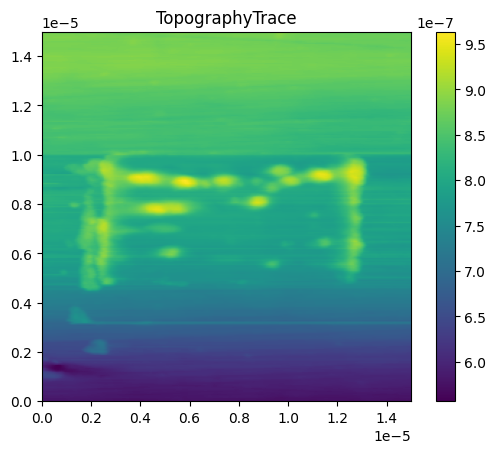

(256, 256)
[0.0e+00 1.5e-05 0.0e+00 1.5e-05]


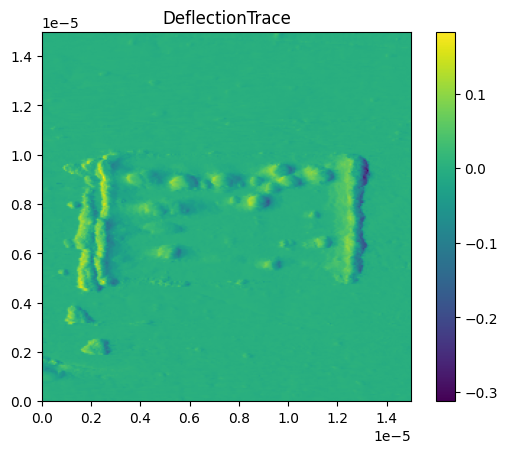

(256, 256)
[0.0e+00 1.5e-05 0.0e+00 1.5e-05]


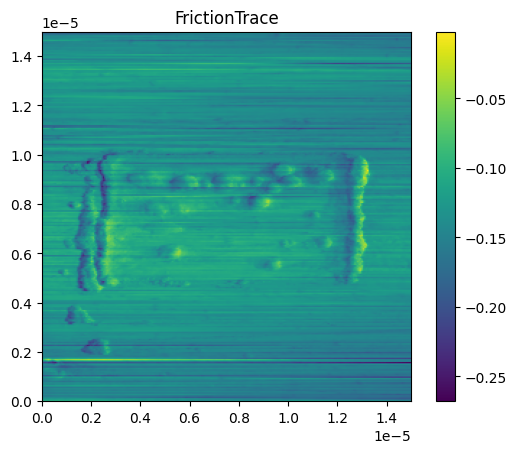

(256, 256)
[0.0e+00 1.5e-05 0.0e+00 1.5e-05]


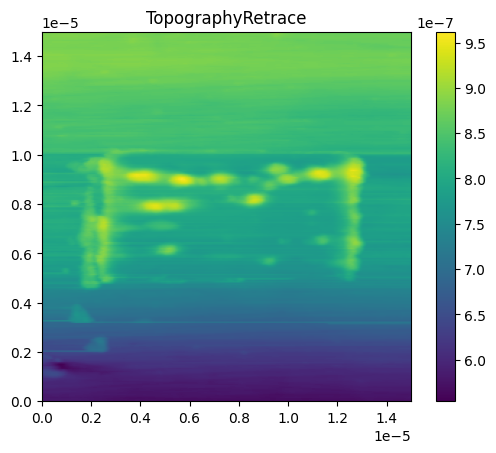

(256, 256)
[0.0e+00 1.5e-05 0.0e+00 1.5e-05]


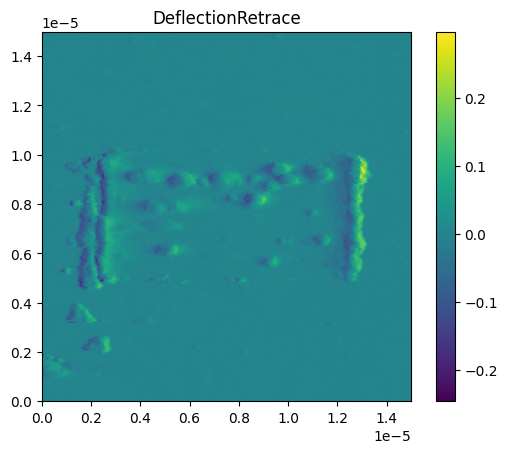

(256, 256)
[0.0e+00 1.5e-05 0.0e+00 1.5e-05]


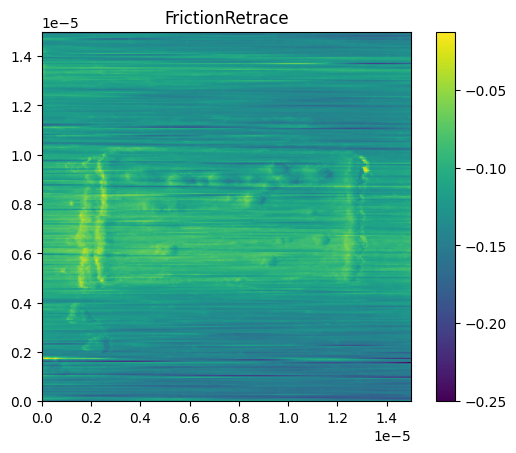

In [4]:
for buffer in file.buffers:
    print(buffer.data.shape)
    print(file.extent)
    plt.imshow(buffer.data, origin='lower', extent=file.extent)
    plt.title(buffer.bufferLabel + buffer.direction)
    plt.colorbar()
    plt.show()